### This notebook produces the Gaussian plots that are in the "Tools for Unbinned Unfolding" paper
### This notebook assumes the Gaussian data is stored in an npy file and that the unfolding models (DNN, BDTs) are already trained + predictions already made and saved to a file
### You can change the paths to the data and models in the first few cells

In [1]:
import numpy as np
import ROOT
import pandas as pd
import matplotlib.pyplot as plt
import modplot
from omnifold import DataLoader, MLP, MultiFold
import gzip
import pickle

2025-03-06 10:04:45.883281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 10:04:45.883320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 10:04:45.884677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 10:04:45.891601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 10:04:46.460374: W tensorflow/compiler/tf2

Horovod instalation found.


No protocol specified
No protocol specified
2025-03-06 10:04:47.766145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-06 10:04:47.766584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-06 10:04:47.807146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/D

In [2]:
gaussian_data_file = "/home/ryan/unfolding_paper/unfolding/gaussian_data.npz"
DNN_saved_weights_path = "/home/ryan/unfolding_paper/unfolding/saved_DNN_gaussian_weights_5iters.pickle.gz"
BDT_binned_weights_file = "/home/ryan/unfolding_paper/unfolding/final_BDT_models/saved_binnedBDT_weights_gaussian.pickle.gz"
unbinned_BDT_model_path = "/home/ryan/unfolding_paper/unfolding/final_BDT_models/"
unbinned_BDT_weights_file = "BDT_gaussian_unbinned_5iterations"

### Loading the data used to train the models

In [3]:
# Defining the binning
# In this notebook sim = reconstructed Monte Carlo & MC = truth level Monte Carlo
MCreco_bins  = 40
MCgen_bins   = 40
MCreco_low   = -10
MCreco_high  = 10
MCgen_low    = -10
MCgen_high   = 10

In [4]:
MCgen_hist  = ROOT.TH1D("MCgen_hist", "MCgen_hist", MCgen_bins, MCgen_low, MCgen_high)
MCreco_hist = ROOT.TH1D("MCreco_hist", "MCreco_hist", MCreco_bins, MCreco_low, MCreco_high)
response = ROOT.RooUnfoldResponse(MCreco_bins, MCreco_low, MCreco_high, MCgen_bins, MCgen_low, MCgen_high)
true_hist     = ROOT.TH1D ("true_hist", "true_hist", MCgen_bins, MCgen_low, MCgen_high)
measured_hist = ROOT.TH1D ("measured_hist", "measured_hist", MCreco_bins, MCreco_low, MCreco_high)

In [5]:
gaussian_data = np.load(gaussian_data_file)

unbinned_MCgen_data = gaussian_data["MC"]
unbinned_MCreco_data = gaussian_data["sim"]
unbinned_truth_data = gaussian_data["truth"]
unbinned_measured_data = gaussian_data["measured"]
MC_pass_reco = gaussian_data["sim_pass_reco"]
measured_pass_reco = gaussian_data["measured_pass_reco"]

In [6]:
MCgen_test = unbinned_MCgen_data[1500000:]
MCreco_test = unbinned_MCreco_data[1500000:]
MC_pass_reco_test = MC_pass_reco[1500000:]

truth_test = unbinned_truth_data[375000:]
measured_test = unbinned_measured_data[375000:]
measured_pass_reco_test = measured_pass_reco[375000:]

In [7]:
num_iterations = 5

In [8]:
for (MC, MCreco, pass_reco) in zip(unbinned_MCgen_data, unbinned_MCreco_data, MC_pass_reco):
    if pass_reco:
        response.Fill(MCreco, MC)
    else:
        response.Miss(MC)

for (measured, pass_reco) in zip(unbinned_measured_data, measured_pass_reco):
    if pass_reco:
        measured_hist.Fill(measured)

### Looking at our ROOT histograms and unbinned data

Text(0.5, 0, 'x')

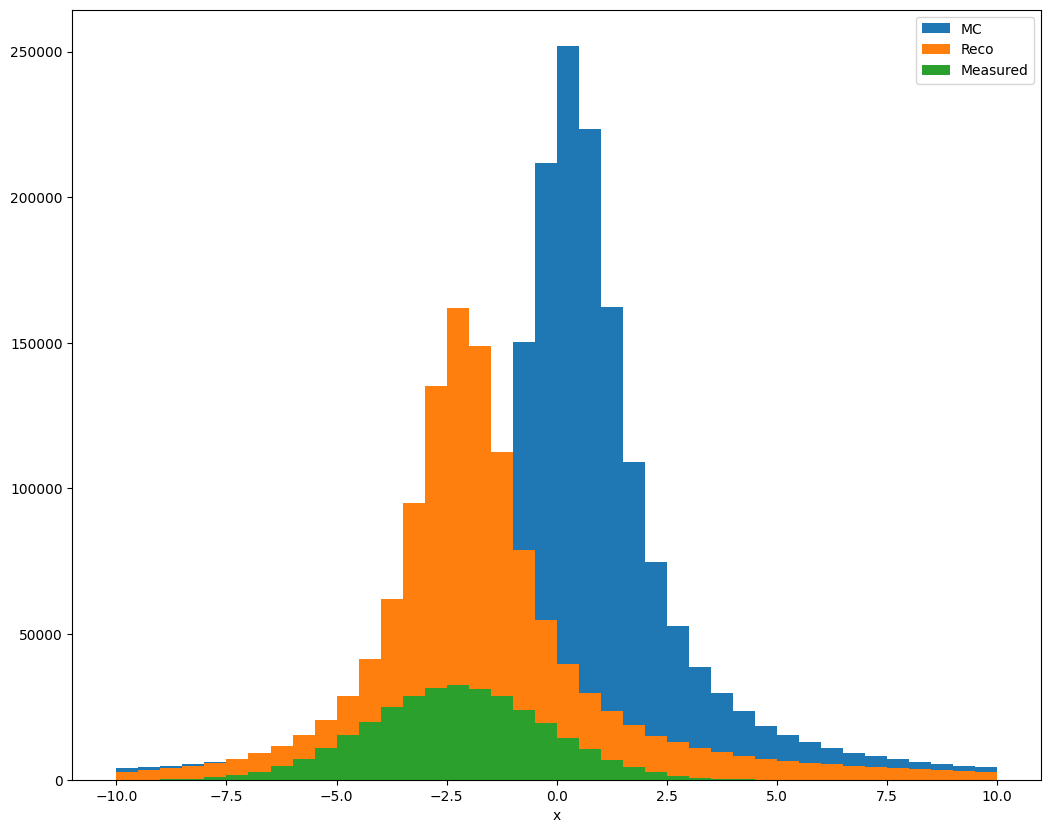

In [9]:
# Plotting unbinned data
fig = plt.figure(figsize=(12.5,10))
plt.hist(unbinned_MCgen_data, bins = MCgen_bins, range=(MCgen_low, MCgen_high), label = "MC", histtype='stepfilled')
plt.hist(unbinned_MCreco_data[MC_pass_reco], bins = MCreco_bins, range=(MCreco_low, MCreco_high), label = "Reco", histtype='stepfilled')
plt.hist(unbinned_measured_data[measured_pass_reco], bins = MCreco_bins, range=(MCreco_low, MCreco_high), label = "Measured", histtype='stepfilled')
plt.legend()
plt.xlabel("x")

### DNN Omnifold

In [10]:
with gzip.open(DNN_saved_weights_path, 'rb') as f:
    DNN_data = pickle.load(f)
    DNN_step2_weights = DNN_data['DNN_weights']

### BDT Binned unfolding

In [11]:
BDT_binned_weights_file = "/home/ryan/unfolding_paper/unfolding/final_BDT_models/saved_binnedBDT_weights_gaussian.pickle.gz"
with gzip.open(BDT_binned_weights_file, 'rb') as f:
    loaded_data = pickle.load(f)
    binned_BDT = loaded_data['binned_BDT']
    binned_BDT_unc = loaded_data['binned_BDT_unc']
    binned_BDT_bincenters = loaded_data['binned_BDT_bincenters']

### BDT unbinned unfolding

In [12]:
def np_to_TVector(array):
    vector = ROOT.TVector(len(array))
    for i, entry in enumerate(array):
        vector[i] = entry
    return vector
def TVector_to_np(vector):
    num_entries = vector.GetNoElements()
    np_array = np.empty([num_entries, ], dtype = np.float32)
    for i in range(num_entries):
        np_array[i] = vector[i]
    return np_array

In [13]:
print("Loading unifold BDT weights")
unifold_bdt_step2_weights = []
MC_pass_reco_vector_test = np_to_TVector(MC_pass_reco_test)
df_MCgen = ROOT.RDF.FromNumpy({"MCgen_test": MCgen_test})
df_MCreco = ROOT.RDF.FromNumpy({"MCreco_test": MCreco_test})

print("Making unifold BDT predictions")
unbinned_bdt = ROOT.RooUnfoldOmnifold()
unbinned_bdt.SetSaveDirectory(unbinned_BDT_model_path)
unbinned_bdt.SetModelName(unbinned_BDT_weights_file)
unbinned_bdt.SetTestMCgenDataFrame(df_MCgen)
unbinned_bdt.SetTestMCrecoDataFrame(df_MCreco)
unbinned_bdt.SetTestMCPassReco(MC_pass_reco_vector_test)
unbinned_bdt_results = unbinned_bdt.TestUnbinnedOmnifold()
unbinned_bdt_step1_weights_TVector = ROOT.std.get[0](unbinned_bdt_results)
unbinned_bdt_step2_weights_TVector = ROOT.std.get[1](unbinned_bdt_results)
unbinned_bdt_step1_weights = TVector_to_np(unbinned_bdt_step1_weights_TVector)
unbinned_bdt_step2_weights = TVector_to_np(unbinned_bdt_step2_weights_TVector)

Loading unifold BDT weights
Making unifold BDT predictions
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_gaussian_unbinned_5iterations_models.pkl for step 1 predictions.
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_gaussian_unbinned_5iterations_models.pkl for step 2 predictions.


In [14]:
# Getting IBU results from RooUnfold
IBU_RooUnfold = ROOT.RooUnfoldBayes(response, measured_hist, num_iterations)
hReco_RooUnfold = IBU_RooUnfold.Hunfold()
ibu_bin_centers = [hReco_RooUnfold.GetBinCenter(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 1)]
ibu_counts = [hReco_RooUnfold.GetBinContent(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 1)]
ibu_bin_edges = [hReco_RooUnfold.GetBinLowEdge(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 2)]
ibu_bin_errors = [hReco_RooUnfold.GetBinError(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 1)]
# Calculate the density-normalized histogram using np.histogram
ibu_density_counts, _ = np.histogram(ibu_bin_centers, bins=ibu_bin_edges, weights=ibu_counts, density=True)
ibu_bin_errors = ibu_bin_errors/(np.sum(ibu_counts)*(ibu_bin_edges[1]-ibu_bin_edges[0]))

Using response matrix priors
Priors:

Vector (40)  is as follows

     |        1  |
------------------
   0 |0.00210836 
   1 |0.00232185 
   2 |0.0025636 
   3 |0.00291237 
   4 |0.00330188 
   5 |0.00359904 
   6 |0.00430254 
   7 |0.00485449 
   8 |0.00564329 
   9 |0.00671458 
  10 |0.0079445 
  11 |0.00979318 
  12 |0.0119564 
  13 |0.0153577 
  14 |0.0198297 
  15 |0.0268654 
  16 |0.0376516 
  17 |0.0548129 
  18 |0.0815903 
  19 |0.115091 
  20 |0.136794 
  21 |0.121421 
  22 |0.0881636 
  23 |0.0593018 
  24 |0.0406335 
  25 |0.0286293 
  26 |0.0210993 
  27 |0.0161693 
  28 |0.0127783 
  29 |0.0100463 
  30 |0.00833564 
  31 |0.00699978 
  32 |0.00589047 
  33 |0.00498269 
  34 |0.00439055 
  35 |0.00378646 
  36 |0.0033399 
  37 |0.00299114 
  38 |0.0026402 
  39 |0.00239193 

Now unfolding...
Iteration : 0
Chi^2 of change 49860.6
Iteration : 1
Chi^2 of change 276.332
Iteration : 2
Chi^2 of change 9.8781
Iteration : 3
Chi^2 of change 2.13141
Iteration : 4
Chi^2 of change 1.

In [15]:
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('legend', fontsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [16]:
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
dnn_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}
bdt_binned_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:purple', 'zorder': 3}
bdt_unbinned_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:blue', 'zorder': 3}

### Making the final plots

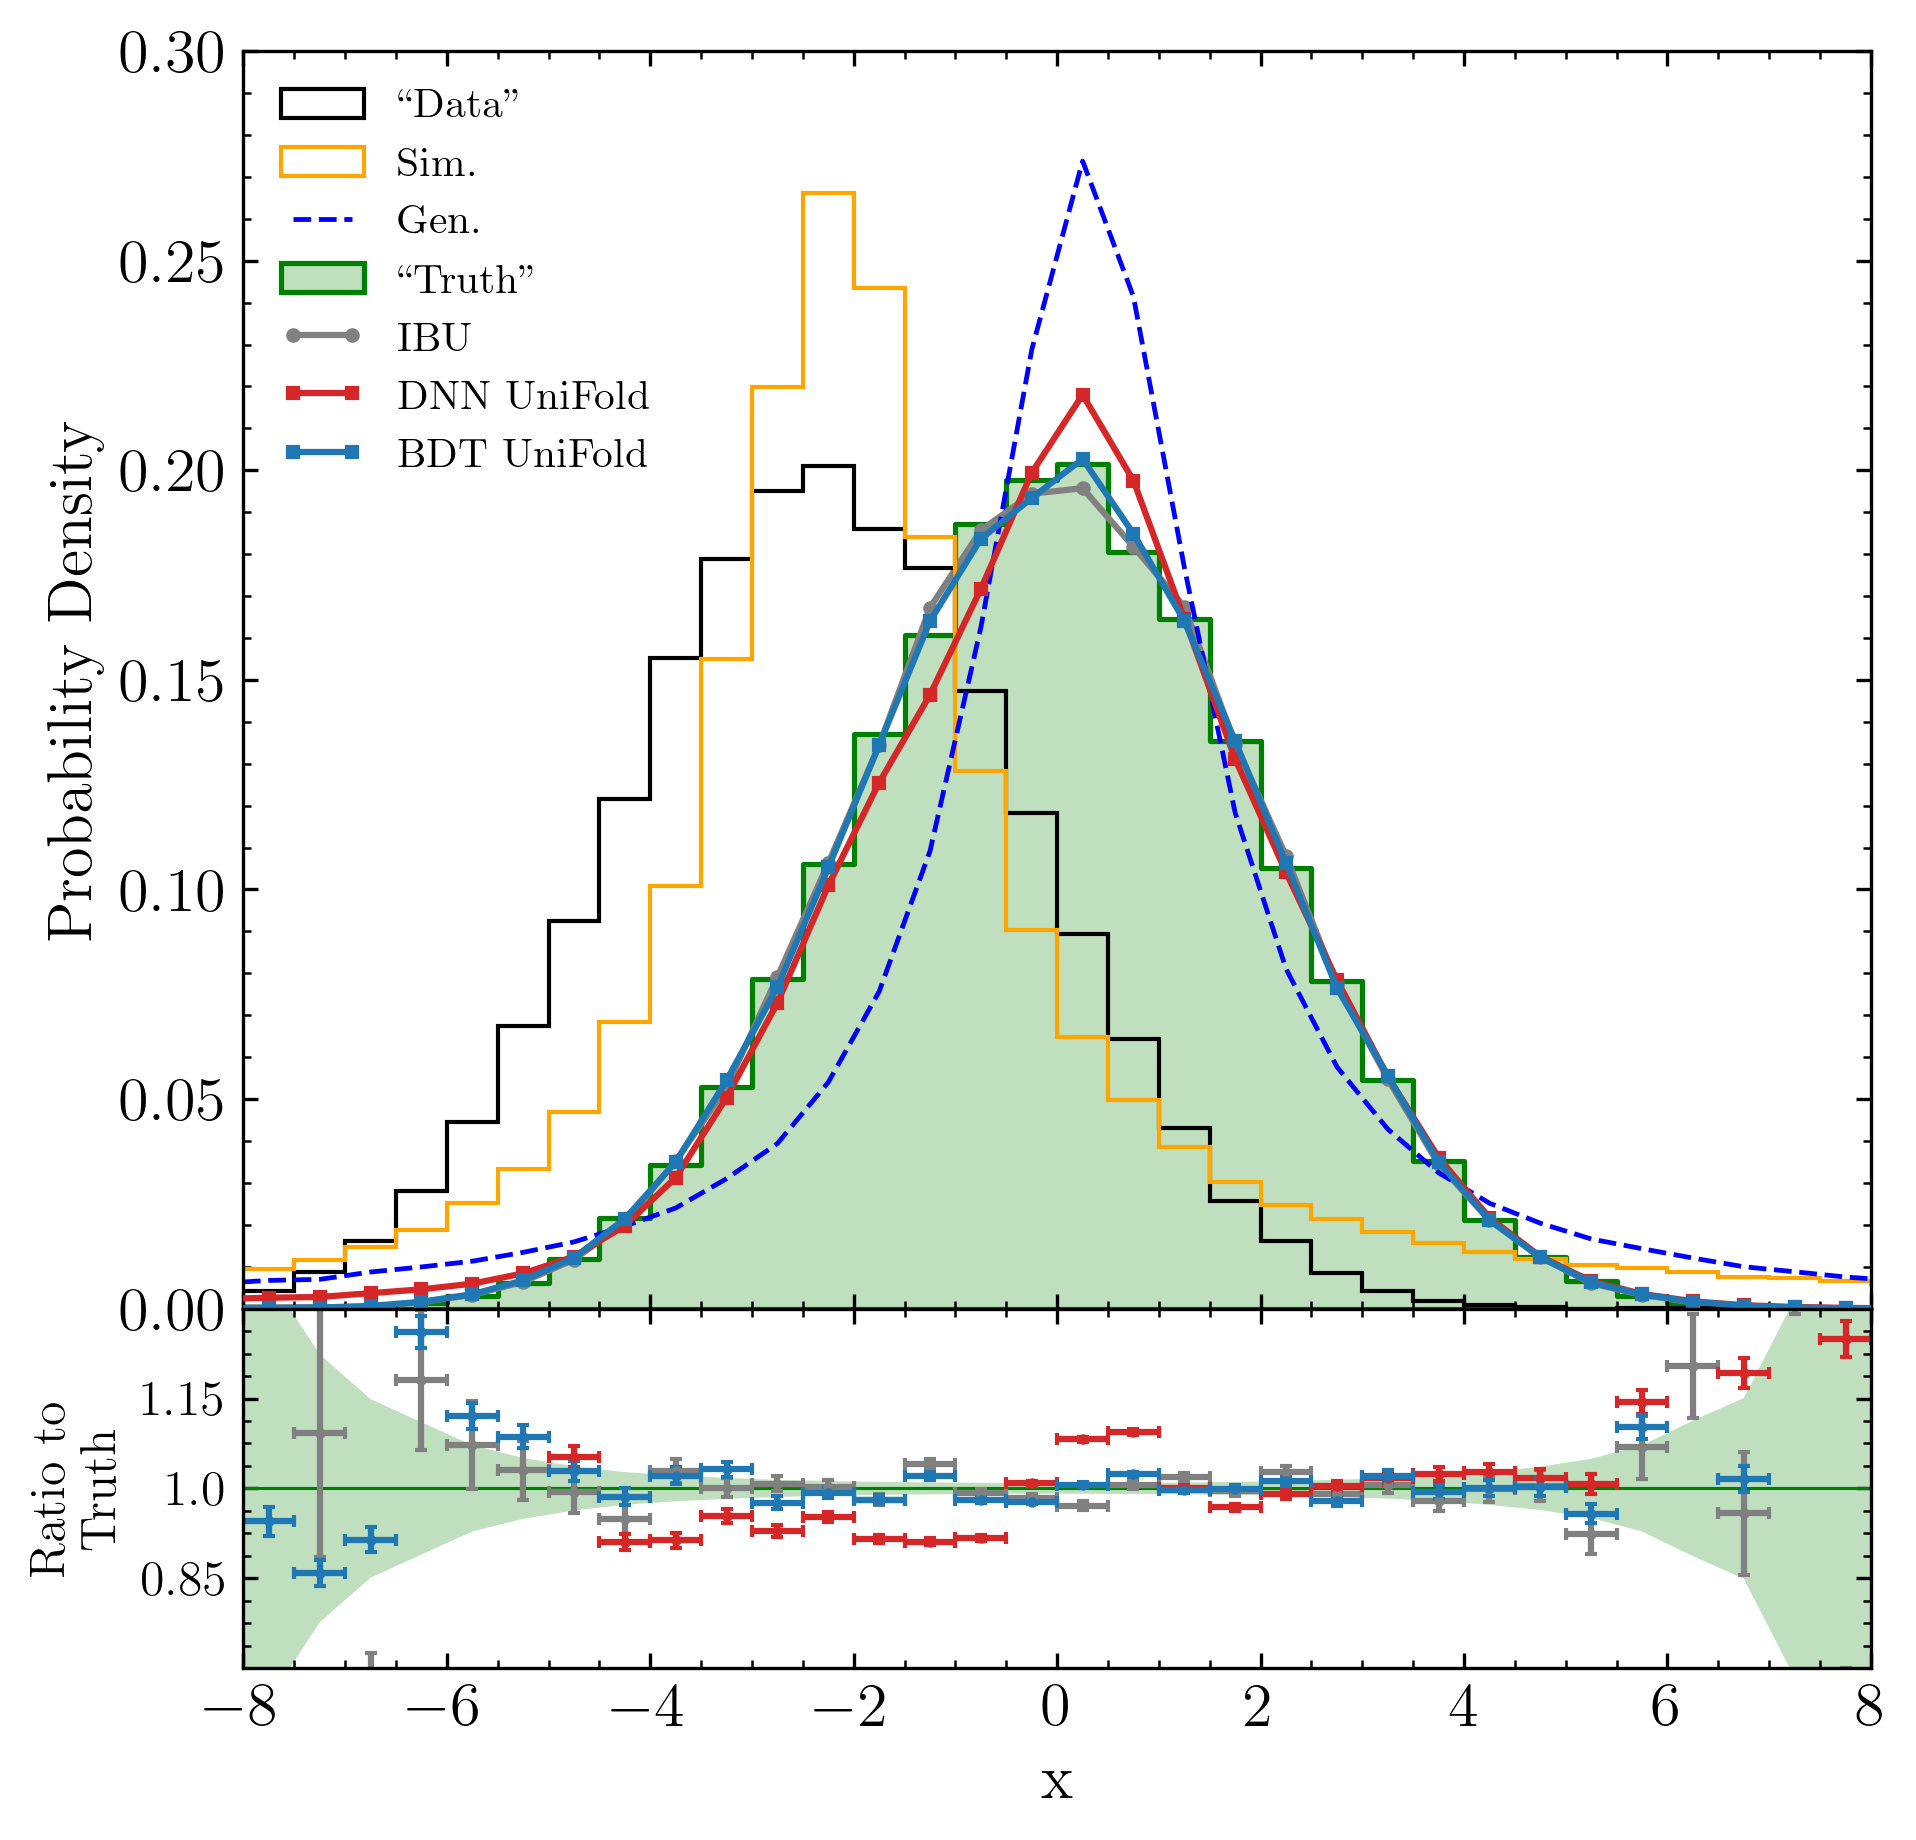

In [17]:
fig, [ax0, ax1] = modplot.axes(figsize=(7,7), xlabel="x", xlim=(-8, 8), ylim=(0,0.3))
        
# Plot the Measured, Sim, Gen, and truth of the Gausian
# Measured
ax0.hist(measured_test[measured_pass_reco_test], bins = MCreco_bins, range = (MCreco_low, MCreco_high), color = 'black', label = '``Data\"', **hist_style)
# Sim
ax0.hist(MCreco_test[MC_pass_reco_test], bins = MCreco_bins, range = (MCreco_low, MCreco_high), color = 'orange', label = 'Sim.', **hist_style)
# Gen
MCgen_hist, MCgen_bin_edges =  np.histogram(MCgen_test, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density=True)
MCgen_bin_centers = (MCgen_bin_edges[:-1] + MCgen_bin_edges[1:]) / 2
ax0.plot(MCgen_bin_centers, MCgen_hist, **gen_style)
# Truth
truth_hist, truth_bin_errors = modplot.calc_hist(truth_test, bins = MCgen_bins, hist_range = (MCgen_low, MCgen_high), density=True)[:2]
_, truth_bin_edges =  np.histogram(truth_test, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density=True)
truth_bin_centers = (truth_bin_edges[:-1] + truth_bin_edges[1:]) / 2
ax0.fill_between(truth_bin_centers, truth_hist, **truth_style)

# Plot the IBU distribution
ax0.plot(ibu_bin_centers, ibu_density_counts, **ibu_style, label='IBU')

# DNN histogram
dnn_unbinned_unfolded_hist, dnn_unbinned_unfolded_hist_errors = modplot.calc_hist(
        MCgen_test, 
        weights = DNN_step2_weights, 
        bins = MCgen_bins,
        hist_range = (MCgen_low, MCgen_high),
        density=True
)[:2]
ax0.plot(truth_bin_centers, dnn_unbinned_unfolded_hist, **dnn_style, label='DNN UniFold')

# Unbinned BDT histogram
unbinned_unfolded_hist, unbinned_unfolded_hist_errors = modplot.calc_hist(
    MCgen_test, 
    weights = unbinned_bdt_step2_weights, 
    bins = MCgen_bins,
    hist_range=(MCgen_low, MCgen_high),
    density=True
)[:2]
ax0.plot(truth_bin_centers, unbinned_unfolded_hist, **bdt_unbinned_style, label='BDT UniFold')

# Calculating the ratios of the unfolded distributions to the truth (with statistical uncertainties)
ibu_ratio = ibu_density_counts / (truth_hist + 10**-50)
dnn_ratio = dnn_unbinned_unfolded_hist /(truth_hist + 10**-50)
bdt_unbinned_ratio = unbinned_unfolded_hist /(truth_hist + 10**-50)
    
# Ratio uncertainties
truth_unc_ratio = truth_bin_errors / (truth_hist + 10**-50)
ibu_unc_ratio = ibu_bin_errors / (truth_hist + 10**-50)
dnn_unc_ratio = dnn_unbinned_unfolded_hist_errors / (truth_hist + 10**-50)
bdt_unbinned_unc_ratio = unbinned_unfolded_hist_errors / (truth_hist + 10**-50)

# Plotting the ratios
# Truth
ax1.plot([np.min(truth_bin_centers), np.max(truth_bin_centers)], [1, 1], '-', color='green', lw=0.75)
ax1.fill_between(
    truth_bin_centers, 
    1 - truth_unc_ratio, 
    1 + truth_unc_ratio,          
    facecolor=truth_style['facecolor'], 
    zorder=-2
)

# IBU
ax1.errorbar(
    ibu_bin_centers, 
    ibu_ratio, 
    xerr=(ibu_bin_centers[1]-ibu_bin_centers[0])/2, 
    yerr=ibu_unc_ratio,                       
    color=ibu_style['color'], 
    **modplot.style('errorbar')
)

# DNN
truth_binwidth = (truth_bin_centers[1]-truth_bin_centers[0])/2
ax1.errorbar(
    truth_bin_centers, 
    dnn_ratio, 
    xerr=truth_binwidth, 
    yerr=dnn_unc_ratio, 
    color=dnn_style['color'], 
    **modplot.style('errorbar')
)
# BDT unbinned
ax1.errorbar(
    truth_bin_centers, 
    bdt_unbinned_ratio, 
    xerr = truth_binwidth, 
    yerr = bdt_unbinned_unc_ratio, 
    color = bdt_unbinned_style['color'], 
    **modplot.style('errorbar')
)

# Plotting legend
modplot.legend(ax=ax0, frameon=False, loc="upper left", ncol=1)

fig.savefig(f'./final_plots/OmniFold_Gaussian_RooUnfoldBDT.pdf', bbox_inches='tight')

### Plotting the binned BDT distribution

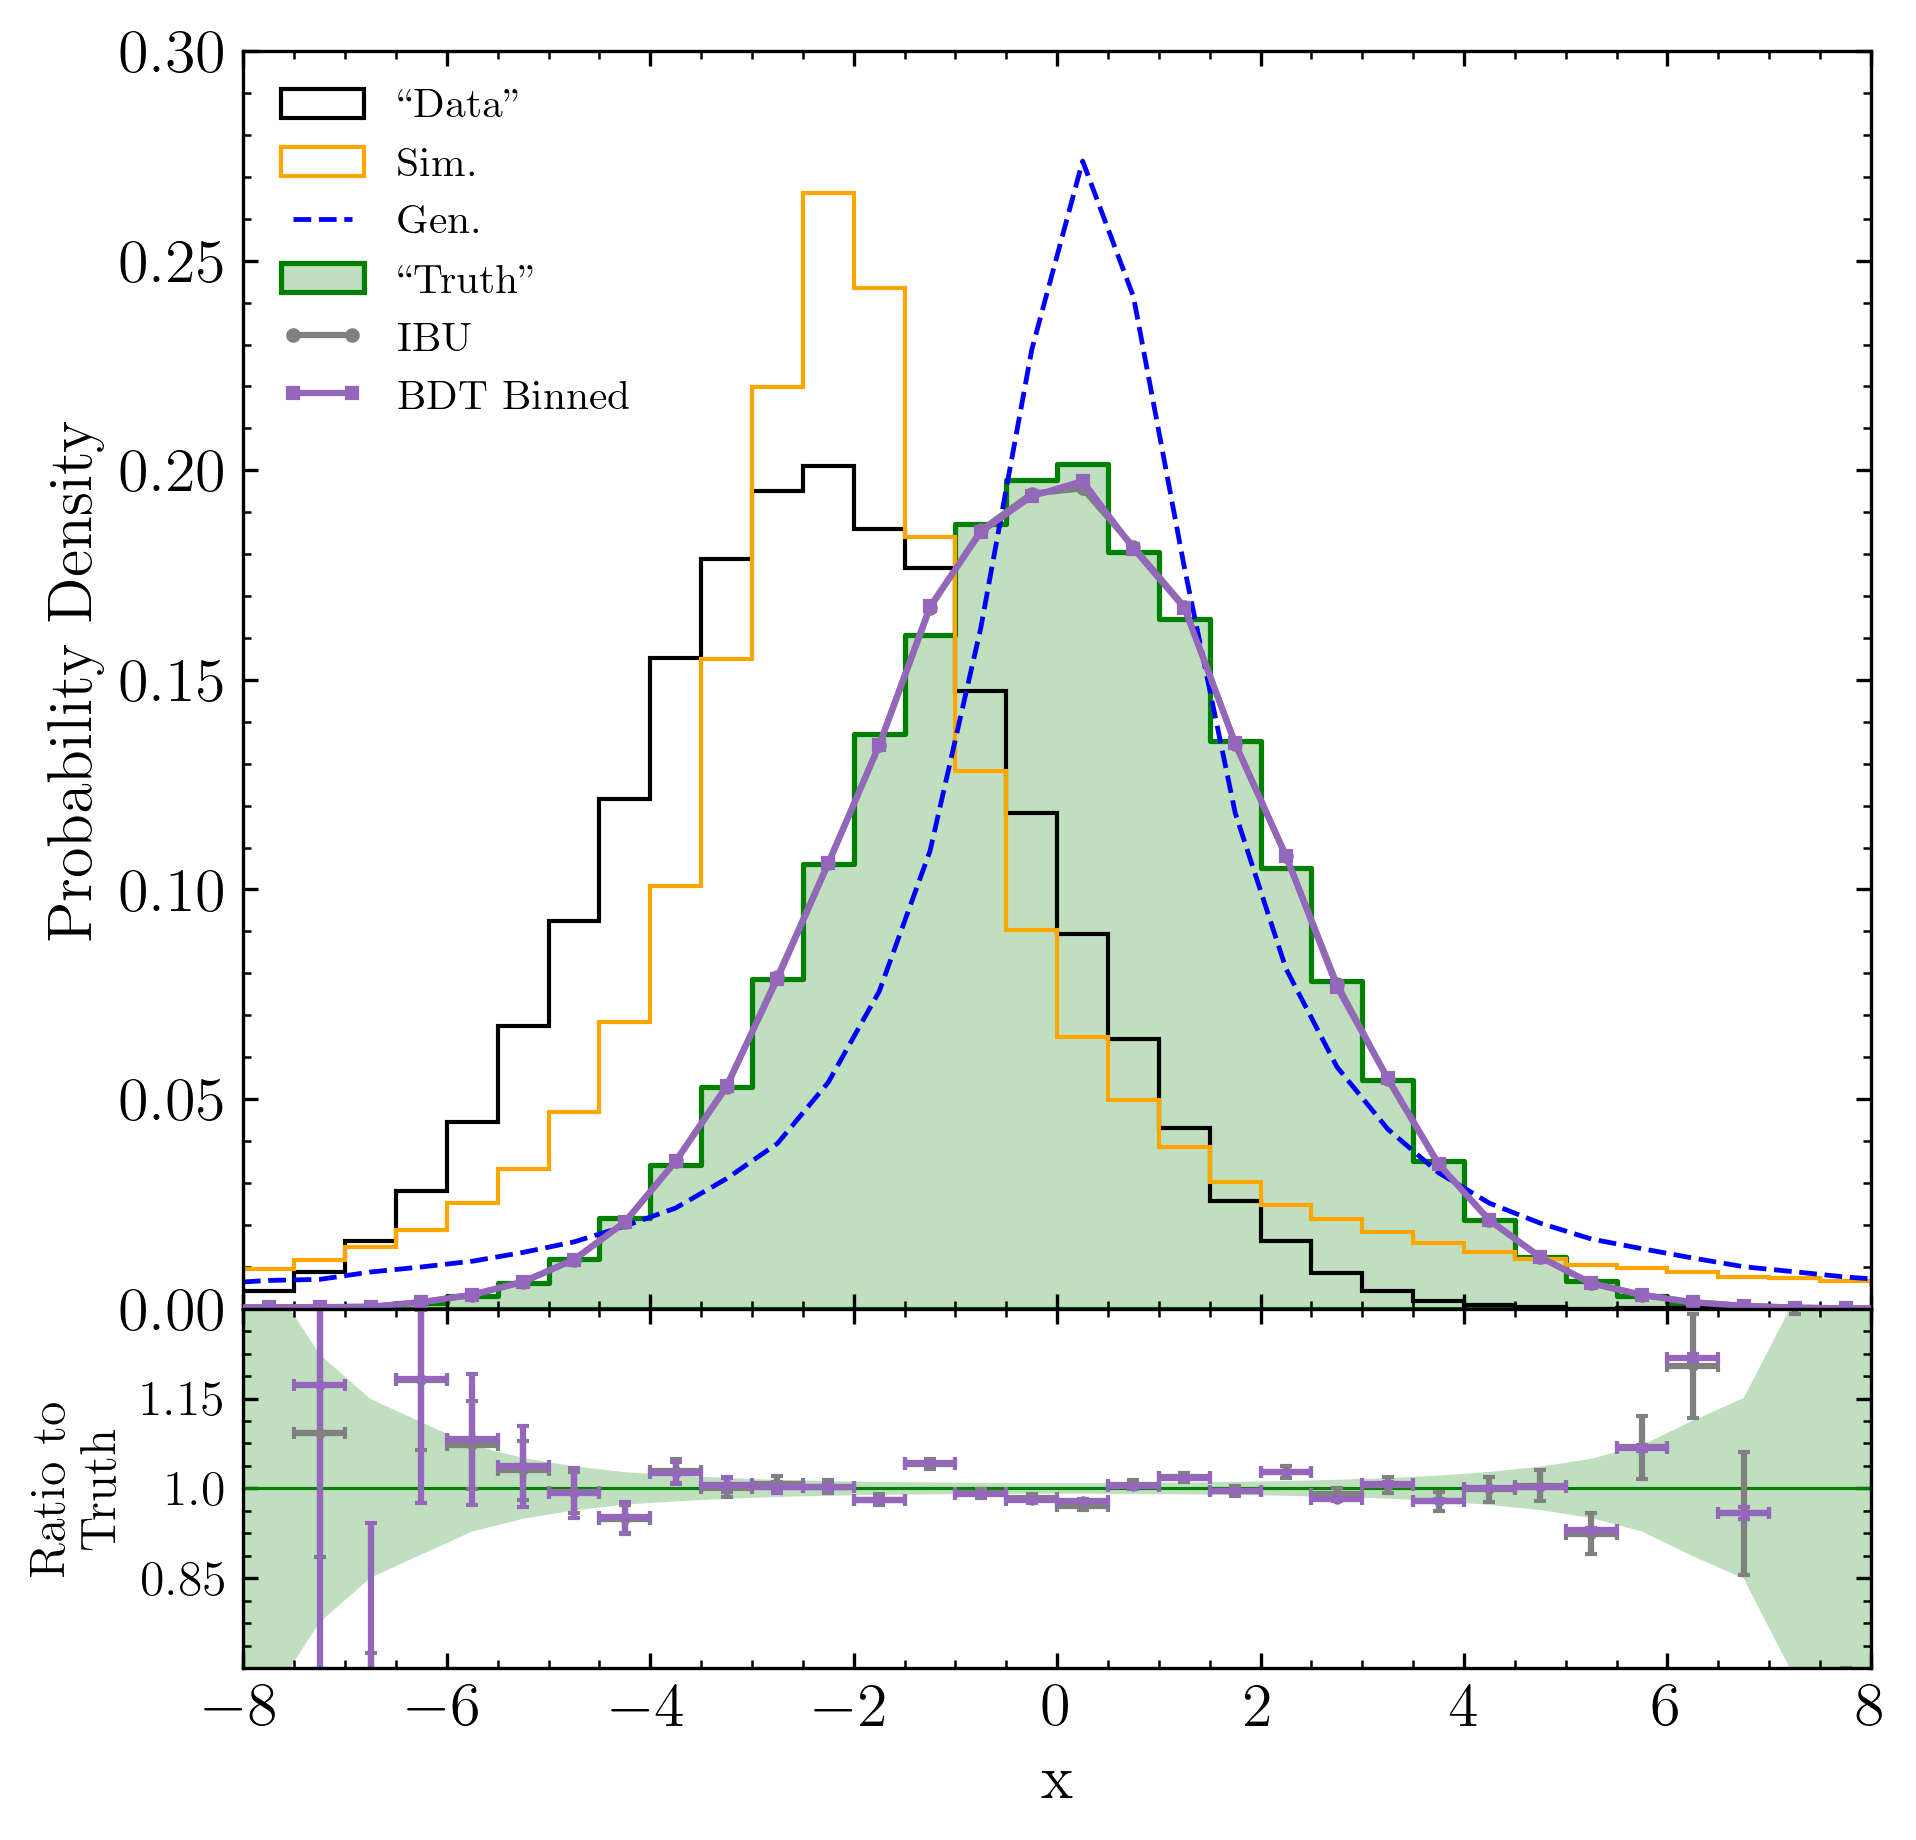

In [18]:
fig, [ax0, ax1] = modplot.axes(figsize=(7,7), xlabel="x", xlim=(-8, 8), ylim=(0,0.3))
        
# Plot the Measured, Sim, Gen, and truth of the Gausian
# Measured
ax0.hist(measured_test[measured_pass_reco_test], bins = MCreco_bins, range = (MCreco_low, MCreco_high), color = 'black', label = '``Data\"', **hist_style)
# Sim
ax0.hist(MCreco_test[MC_pass_reco_test], bins = MCreco_bins, range = (MCreco_low, MCreco_high), color = 'orange', label = 'Sim.', **hist_style)
# Gen
MCgen_hist, MCgen_bin_edges =  np.histogram(MCgen_test, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density=True)
MCgen_bin_centers = (MCgen_bin_edges[:-1] + MCgen_bin_edges[1:]) / 2
ax0.plot(MCgen_bin_centers, MCgen_hist, **gen_style)
# Truth
truth_hist, truth_bin_errors = modplot.calc_hist(truth_test, bins = MCgen_bins, hist_range = (MCgen_low, MCgen_high), density=True)[:2]
_, truth_bin_edges =  np.histogram(truth_test, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density=True)
truth_bin_centers = (truth_bin_edges[:-1] + truth_bin_edges[1:]) / 2
ax0.fill_between(truth_bin_centers, truth_hist, **truth_style)

# Plot the IBU & Binned BDT distributions
ax0.plot(ibu_bin_centers, ibu_density_counts, **ibu_style, label='IBU')
ax0.plot(binned_BDT_bincenters, binned_BDT, **bdt_binned_style, label='BDT Binned')

# Calculating the ratios of the unfolded distributions to the truth (with statistical uncertainties)
ibu_ratio = ibu_density_counts / (truth_hist + 10**-50)
bdt_binned_ratio = binned_BDT /(truth_hist + 10**-50)

# Ratio uncertainties
truth_unc_ratio = truth_bin_errors / (truth_hist + 10**-50)
ibu_unc_ratio = ibu_bin_errors / (truth_hist + 10**-50)
bdt_binned_unc_ratio = binned_BDT_unc / (truth_hist + 10**-50)

# Plotting the ratios
# Truth
ax1.plot([np.min(truth_bin_centers), np.max(truth_bin_centers)], [1, 1], '-', color='green', lw=0.75)
ax1.fill_between(
    truth_bin_centers, 
    1 - truth_unc_ratio, 
    1 + truth_unc_ratio,          
    facecolor=truth_style['facecolor'], 
    zorder=-2
)
# IBU
ax1.errorbar(
    ibu_bin_centers, 
    ibu_ratio, 
    xerr = (ibu_bin_centers[1]-ibu_bin_centers[0])/2, 
    yerr = ibu_unc_ratio,                       
    color =ibu_style['color'], 
    **modplot.style('errorbar')
)

truth_binwidth = (truth_bin_centers[1]-truth_bin_centers[0])/2
ax1.errorbar(
    truth_bin_centers, 
    bdt_binned_ratio, 
    xerr = truth_binwidth, 
    yerr = bdt_binned_unc_ratio, 
    color = bdt_binned_style['color'], 
    **modplot.style('errorbar')
)

# Plotting legend
modplot.legend(ax=ax0, frameon=False, loc="upper left", ncol=1)

fig.savefig(f'./final_plots/OmniFold_Gaussian_BinnedvsIBU_RooUnfoldBDT_5iterations.pdf', bbox_inches='tight')